2D Mucus Layer Simulation 
Simulating ~150 µm human colon mucus layer with COMETS

**Grid:** 30 x 15 (300 um wide x 150 um deep)

**Species:** *Bifidobacterium longum infantis*, *Eubacterium hallii*

**Scenario:** Glucose supplied at top (lumen), diffuses downward; cross-feeding via lactate/acetate/butyrate

In [1]:
%reset -f

import os
# COMETS and Gurobi paths (macOS) 
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
##Load COBRA Models

base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'

base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

print(f"Bifido: {len(base1.reactions)} rxns, {len(base1.metabolites)} mets, {len(base1.exchanges)} exchanges")
print(f"Eubacterium: {len(base2.reactions)} rxns, {len(base2.metabolites)} mets, {len(base2.exchanges)} exchanges")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Bifido: 1032 rxns, 932 mets, 163 exchanges
Eubacterium: 1051 rxns, 980 mets, 120 exchanges


In [3]:
#FBA for Both Models 

for label, model in [('Bifido', base1), ('Eubacterium', base2)]:
    with model:
        for rxn in model.exchanges:
            rxn.lower_bound = -1000
            rxn.upper_bound = 1000
        sol = model.optimize()
        print(f"{label} max growth (unlimited media): {sol.objective_value:.4f} 1/h")

Bifido max growth (unlimited media): 60.8202 1/h
Eubacterium max growth (unlimited media): 67.1662 1/h


In [4]:
# Build Exchange Metabolite Union & Add Missing Exchanges

# Map metabolite_id -> exchange_reaction_id for each model
met_to_ex1, met_to_ex2 = {}, {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met_to_ex1[list(rxn.metabolites.keys())[0].id] = rxn.id
for rxn in base2.exchanges:
    if rxn.metabolites:
        met_to_ex2[list(rxn.metabolites.keys())[0].id] = rxn.id


all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())
print(f"Total unique external metabolites: {len(all_ext_mets)}")


# COMETS fix for index out of range error
def add_missing_closed_exchanges(model, met_to_ex_self, all_ext_mets, label):
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}
    added = 0
    for met_id in all_ext_mets:
        if met_id in met_to_ex_self:
            continue
        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
        rxn_id = f'EX_added_{met_id}'
        if rxn_id in rxn_ids:
            continue
        rxn = cb.Reaction(rxn_id)
        rxn.name = f'Dummy exchange for {met_id} (closed)'
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)
        added += 1
    print(f'[{label}] Added {added} closed dummy exchanges')

add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, 'Bifido')
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, 'Eubacterium')

Total unique external metabolites: 188
[Bifido] Added 25 closed dummy exchanges
[Eubacterium] Added 68 closed dummy exchanges


In [5]:
# COMETS Models

for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

bif = c.model(base1)
eub = c.model(base2)

bif.open_exchanges()
eub.open_exchanges()

# Clean non-EX exchanges (COMETS fix)
for m in [bif, eub]:
    ex_mask = m.reactions['EXCH'].isin([True, 'True'])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df['REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            m.reactions.loc[m.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            m.reactions.loc[m.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

print(f'Bifido COMETS: {len(bif.reactions)} reactions')
print(f'Eubacterium COMETS: {len(eub.reactions)} reactions')

Bifido COMETS: 1057 reactions
Eubacterium COMETS: 1119 reactions


In [6]:
# GRID GEOMETRY

GRID_X = 30                         # cells wide
GRID_Y = 15                         # cells deep (mucus thickness direction)
MUCUS_THICKNESS_UM = 150            # um — human colon mucus layer

SPACE_WIDTH = MUCUS_THICKNESS_UM / GRID_Y / 1e4   # cm per cell
# = 150/15/10000 = 0.001 cm = 10 um per cell

BOX_VOL_CM3 = SPACE_WIDTH ** 3       # cm3 per box = 1e-9 cm3
BOX_VOL_ML  = BOX_VOL_CM3            # 1 cm3 = 1 mL
BOX_VOL_L   = BOX_VOL_ML * 1e-3      # 1e-12 L


# concentration (mM) -> amount (mmol) per box 
def mM_to_mmol(conc_mM):
    """Convert mM (= mmol/L) to mmol amount per COMETS box"""
    return conc_mM * BOX_VOL_L   # mmol/L * L = mmol

def mmol_to_mM(amount_mmol):
    """Convert mmol amount per box back to mM concentration."""
    return amount_mmol / BOX_VOL_L


# Aqueous diffusion at 25C (literature values)
D_glucose_aq   = 6.7e-6   # cm2/s — glucose 
D_lactate_aq   = 1.1e-5   # cm2/s — lactate
D_acetate_aq   = 1.2e-5   # cm2/s — acetate
D_butyrate_aq  = 0.9e-5   # cm2/s — butyrate
D_generic_aq   = 8.0e-6   # cm2/s — small molecule


MUCUS_FACTOR_GLUCOSE = 0.06     # 6% of aqueous diffusion
MUCUS_FACTOR_SECRETED = 0.003   # 0.3% of aqueous diffusion
MUCUS_FACTOR_DEFAULT = 0.008    # 0.8% of aqueous diffusion


# In dense mucus
D_GLUCOSE  = D_glucose_aq  * MUCUS_FACTOR_GLUCOSE    # 4.02e-7 cm2/s
D_LACTATE  = D_lactate_aq  * MUCUS_FACTOR_SECRETED   # 3.3e-8 cm2/s
D_ACETATE  = D_acetate_aq  * MUCUS_FACTOR_SECRETED   # 3.6e-8 cm2/s
D_BUTYRATE = D_butyrate_aq * MUCUS_FACTOR_SECRETED   # 2.7e-8 cm2/s
D_DEFAULT  = D_generic_aq  * MUCUS_FACTOR_DEFAULT    # 6.4e-8 cm2/s


# Diffusion Timescale
L = GRID_Y * SPACE_WIDTH  # total depth in cm

TIME_STEP = 0.01          # hours per cycle
NUM_DIFF_PER_STEP = 10    # diffusion substeps per cycle
KM_VALUE = 5e-4           # mmol/cm³ = 0.5 mM 


print(f"Diffusion timescale (tau = L^2 / 2D)") 
print(f" \n Mucus depth: {L*1e4:.0f} um = {L} cm")
for name, D in [('Glucose', D_GLUCOSE), ('Lactate', D_LACTATE),
                ('Acetate', D_ACETATE), ('Butyrate', D_BUTYRATE)]:
    tau_s = L**2 / (2 * D)
    tau_min = tau_s / 60
    print(f"  {name:12s}: tau = {tau_s:.0f} s = {tau_min:.1f} min")

Diffusion timescale (tau = L^2 / 2D)
 
 Mucus depth: 150 um = 0.015 cm
  Glucose     : tau = 280 s = 4.7 min
  Lactate     : tau = 3409 s = 56.8 min
  Acetate     : tau = 3125 s = 52.1 min
  Butyrate    : tau = 4167 s = 69.4 min


In [7]:
# Metabolite Concentrations

GLC_CONC_mM = 10.0         
GLC_TOP = mM_to_mmol(GLC_CONC_mM) 

WATER_AMOUNT = 1e-4         # mmol/box (≈ 10^8 mM, unlimited)

MAJOR_ION_CONC = 5.0
MAJOR_ION = mM_to_mmol(MAJOR_ION_CONC)

AA_CONC = 2.0   #amino acid concentration
AA_AMOUNT = mM_to_mmol(AA_CONC)

TRACE_CONC = 0.1  #Trace metals
TRACE_AMOUNT = mM_to_mmol(TRACE_CONC)

VIT_CONC = 0.1
VIT_AMOUNT = mM_to_mmol(VIT_CONC)


print(f"METABOLITE AMOUNTS PER BOX")
print(f"\n  Glucose (top):  {GLC_TOP:.2e} mmol  ({GLC_CONC_mM} mM)")
print(f"  Water/H+:       {WATER_AMOUNT:.2e} mmol  (unlimited)")
print(f"  Major ions:     {MAJOR_ION:.2e} mmol  ({MAJOR_ION_CONC} mM)")
print(f"  Amino acids:    {AA_AMOUNT:.2e} mmol  ({AA_CONC} mM)")
print(f"  Trace metals:   {TRACE_AMOUNT:.2e} mmol  ({TRACE_CONC} mM)")
print(f"  Vitamins:       {VIT_AMOUNT:.2e} mmol  ({VIT_CONC} mM)")

METABOLITE AMOUNTS PER BOX

  Glucose (top):  1.00e-11 mmol  (10.0 mM)
  Water/H+:       1.00e-04 mmol  (unlimited)
  Major ions:     5.00e-12 mmol  (5.0 mM)
  Amino acids:    2.00e-12 mmol  (2.0 mM)
  Trace metals:   1.00e-13 mmol  (0.1 mM)
  Vitamins:       1.00e-13 mmol  (0.1 mM)


In [ ]:
# media metabolites

water_proton_ids = {'h2o[e]'}
major_ion_ids = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]',}
trace_metal_ids = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]',}
vitamin_ids = {'ribflv[e]', 'pnto_R[e]', 'nac[e]','hxan[e]',}
aa_ids = {'ala_L[e]', 'asn_L[e]','his_L[e]','leu_L[e]', 'lys_L[e]', 'met_L[e]', 'glycys[e]','glyglu[e]',}
glucose_id = 'glc_D[e]'


# # Classify each metabolite
met_categories = {}
for met_id in all_ext_mets:
    if met_id == glucose_id:
        met_categories[met_id] = ('glucose', GLC_TOP)
    elif met_id in water_proton_ids:
        met_categories[met_id] = ('water_proton', WATER_AMOUNT)
    elif met_id in major_ion_ids:
        met_categories[met_id] = ('major_ion', MAJOR_ION)
    elif met_id in trace_metal_ids:
        met_categories[met_id] = ('trace_metal', TRACE_AMOUNT)
    elif met_id in vitamin_ids:
        met_categories[met_id] = ('vitamin', VIT_AMOUNT)
    elif met_id in aa_ids:
        met_categories[met_id] = ('amino_acid', AA_AMOUNT)   

In [ ]:
INIT_BIOMASS = 5e-10   # grams ~ 500 bacteria 

x_bif = 7              # left side
x_eub = 22             # right side 
y_init = 2             # 20 um into mucus

bif.initial_pop = [[x_bif, y_init, INIT_BIOMASS]]
eub.initial_pop = [[x_eub, y_init, INIT_BIOMASS]]

# layout
layout = c.layout([bif, eub])
layout.grid = [GRID_X, GRID_Y]

# Zero all metabolites
for met in all_ext_mets:
    layout.set_specific_metabolite(met, 0.0)
    layout.set_specific_refresh(met, 0.0)

# set nutrients static
for met_id, (category, amount) in met_categories.items():
    if category == 'glucose':
        continue
    if amount > 0:
        layout.set_specific_metabolite(met_id, amount)
        layout.set_specific_static(met_id, amount)


#  Glucose: top row static, bottom row zero 
for x in range(GRID_X):
    layout.set_specific_metabolite_at_location(glucose_id, (x, 0), GLC_TOP)
    layout.set_specific_static_at_location(glucose_id, (x, 0), GLC_TOP)

for x in range(GRID_X):
    layout.set_specific_metabolite_at_location(glucose_id, (x, GRID_Y - 1), 0.0)
    layout.set_specific_static_at_location(glucose_id, (x, GRID_Y - 1), 0.0)


#  Metabolite specific diffusion (cm2/s)
layout.set_specific_metabolite_diffusion(glucose_id, D_GLUCOSE)
secreted_diffusion = { 'lac_L[e]': D_LACTATE, 'ac[e]': D_ACETATE, 'but[e]':   D_BUTYRATE,}

for met, d_val in secreted_diffusion.items():
    if met in all_ext_mets:
        layout.set_specific_metabolite_diffusion(met, d_val)

In [ ]:
# Biomass Motion Parameters

# bacteria are non-motile in mucus. very slow biomass spreading
D0_biomass = 1e-10     # cm²/s — baseline (non-motile, viscous mucus)
Dn_biomass = 1e-8      # cm²/s — enhanced at high density (mechanical pushing)
n_exp      = 1.0       # linear density dependence
N_hill     = 2.0       # Hill coefficient for growth-dependent diffusion
K_half     = 1e-12     # g — half-saturation for Hill function

for m in [bif, eub]:
    m.add_nonlinear_diffusion_parameters(D0_biomass, Dn_biomass, n_exp, N_hill, K_half)

In [11]:
#Parameters

params = c.params()
params.set_param('maxCycles', 600)         
params.set_param('timeStep', 0.01)             # 0.01 h = 36 s per cycle

params.set_param('spaceWidth', SPACE_WIDTH)    # 0.001 cm = 10 um
params.set_param('exchangestyle', 'Monod Style')
params.set_param('defaultVmax', 20.0)          # mmol/g/h
params.set_param('defaultKm', 5e-4)            # mmol/cm3 = 0.5 mM
params.set_param('defaultHill', 1)             # standard Monod
params.set_param('defaultDiffConst', D_DEFAULT)  # cm2/s
params.set_param('numDiffPerStep', 10)

params.set_param('biomassMotionStyle', 'ConvNonlin Diffusion 2D')
params.set_param('growthDiffRate', 0.0)

params.set_param('maxSpaceBiomass', 1e-9)    # g
params.set_param('minSpaceBiomass', 1e-14)   # g
params.set_param('allowCellOverlap', True)
params.set_param('deathRate', 0.0)

LOG_RATE = 5  
params.set_param('writeBiomassLog', True)
params.set_param('BiomassLogRate', LOG_RATE)
params.set_param('writeMediaLog', True)
params.set_param('MediaLogRate', LOG_RATE)
params.set_param('writeFluxLog', True)
params.set_param('FluxLogRate', LOG_RATE)
params.set_param('writeTotalBiomassLog', True)
params.set_param('totalBiomassLogRate', LOG_RATE)

In [12]:
# Simulation

sim = c.comets(layout, params)
sim.run()
print("\nSimulation complete.")


Running COMETS simulation ...

Debug Here ...
Done!

Simulation complete.


In [13]:
# Output

output_lines = str(sim.run_output).strip().split('\n')
print("Last 25 lines of COMETS output")
for line in output_lines[-25:]:
    print(line)

Last 25 lines of COMETS output
total_diff_time  16
Total biomass:
Model Bifido.cmd: 1.0449827347823025E-9
Model Eubacterium.cmd: 3.1626195449274777E-9
Cycle 598
total_fba_time  575
total_diff_time  18
Total biomass:
Model Bifido.cmd: 1.046284909353798E-9
Model Eubacterium.cmd: 3.1688376782773844E-9
Cycle 599
total_fba_time  576
total_diff_time  16
Total biomass:
Model Bifido.cmd: 1.0475871300416768E-9
Model Eubacterium.cmd: 3.1750560194737742E-9
Cycle 600
total_fba_time  577
total_diff_time  17
Total biomass:
Model Bifido.cmd: 1.0488893975850928E-9
Model Eubacterium.cmd: 3.1812755209267755E-9
Cycle 601
End of simulation
Total time = 225.045s


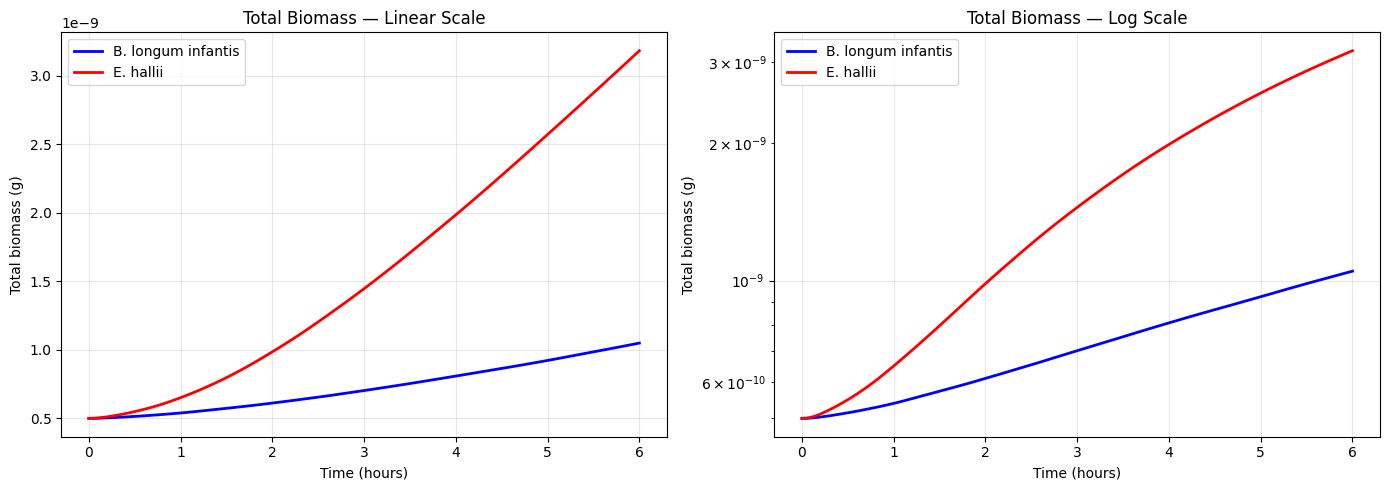

Bifido:       5.00e-10 → 1.05e-09  (x2.1)
Eubacterium:  5.00e-10 → 3.18e-09  (x6.4)


In [14]:
# Total Biomass Over Time

tb = sim.total_biomass
time_h = tb['cycle'] * 0.01 

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax = axes[0]
ax.plot(time_h, tb['Bifido'], 'b-', label='B. longum infantis', linewidth=2)
ax.plot(time_h, tb['Eubacterium'], 'r-', label='E. hallii', linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total biomass (g)')
ax.set_title('Total Biomass — Linear Scale')
ax.legend()
ax.grid(True, alpha=0.3)

# Log scale
ax = axes[1]
ax.semilogy(time_h, tb['Bifido'].clip(lower=1e-20), 'b-', label='B. longum infantis', linewidth=2)
ax.semilogy(time_h, tb['Eubacterium'].clip(lower=1e-20), 'r-', label='E. hallii', linewidth=2)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total biomass (g)')
ax.set_title('Total Biomass — Log Scale')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('total_biomass.png', dpi=150, bbox_inches='tight')
plt.show()

# Growth summary
bif_init = tb['Bifido'].iloc[0]
bif_final = tb['Bifido'].iloc[-1]
eub_init = tb['Eubacterium'].iloc[0]
eub_final = tb['Eubacterium'].iloc[-1]
print(f"Bifido:       {bif_init:.2e} → {bif_final:.2e}  (x{bif_final/max(bif_init,1e-30):.1f})")
print(f"Eubacterium:  {eub_init:.2e} → {eub_final:.2e}  (x{eub_final/max(eub_init,1e-30):.1f})")

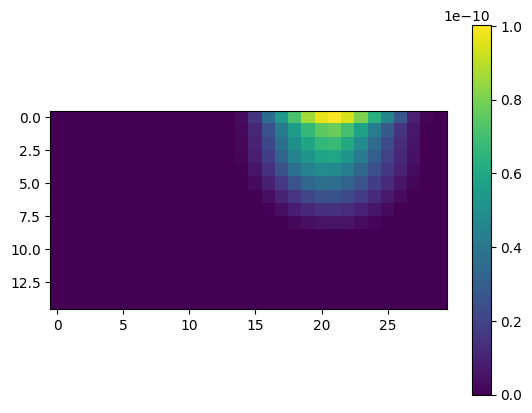

In [15]:
im = sim.get_biomass_image("Eubacterium", 600)
im = np.roll(im, shift=1, axis=1) # shift , fixing a comets bug
plt.imshow(im.T, origin="upper") 
plt.colorbar()
plt.show()

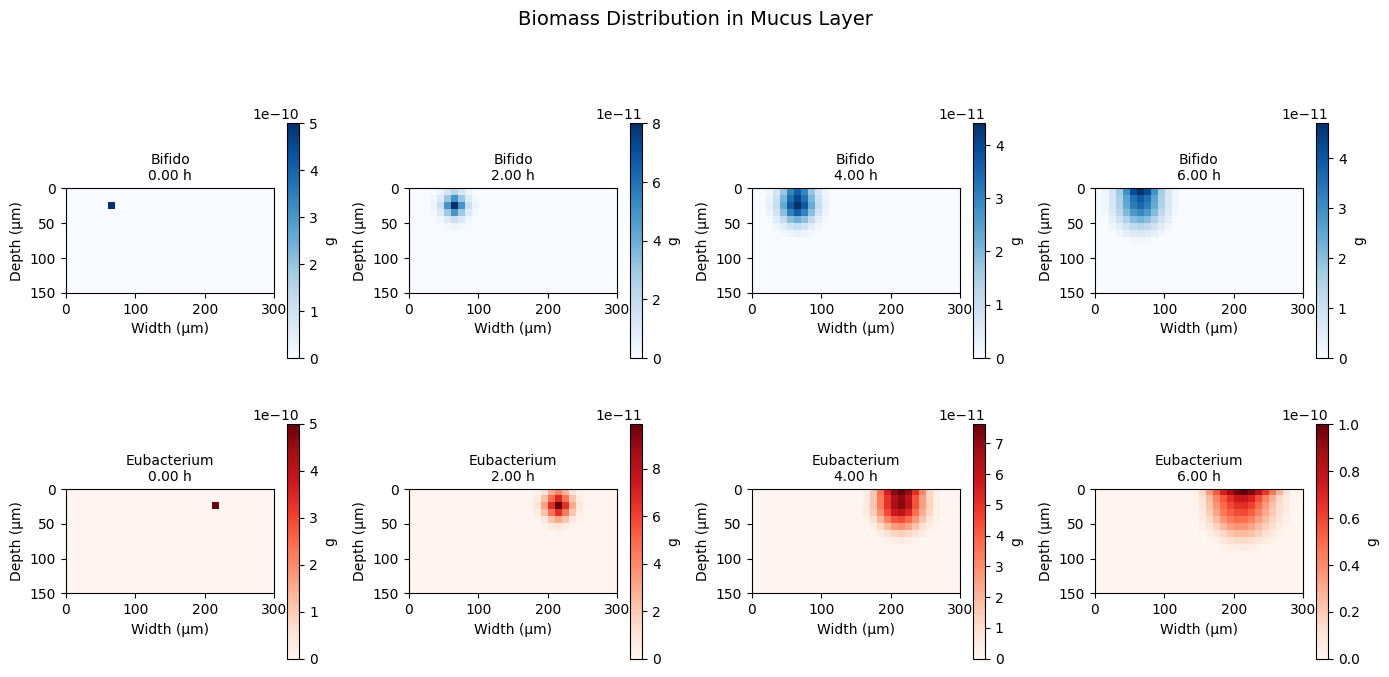

In [16]:
# Biomass Heatmaps Over Time
cycles = [0, 200, 400, 600]  

fig, axes = plt.subplots(2, len(cycles), figsize=(3.5*len(cycles), 7))
if len(cycles) == 1:
    axes = axes.reshape(2, 1)

for i, cyc in enumerate(cycles):
    for j, (species, cmap) in enumerate([('Bifido', 'Blues'), ('Eubacterium', 'Reds')]):
        ax = axes[j, i]
        im = sim.get_biomass_image(species, cyc)
        im = np.roll(im, shift=1, axis=1) # shift , fixing a comets bug

        pcm = ax.imshow(im.T, origin='upper', cmap=cmap, aspect='equal',
                        extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0])
        ax.set_title(f'{species}\n{cyc*0.01:.2f} h', fontsize=10)
        ax.set_xlabel('Width (µm)')
        ax.set_ylabel('Depth (µm)')
        plt.colorbar(pcm, ax=ax, shrink=0.7, label='g')

plt.suptitle('Biomass Distribution in Mucus Layer', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

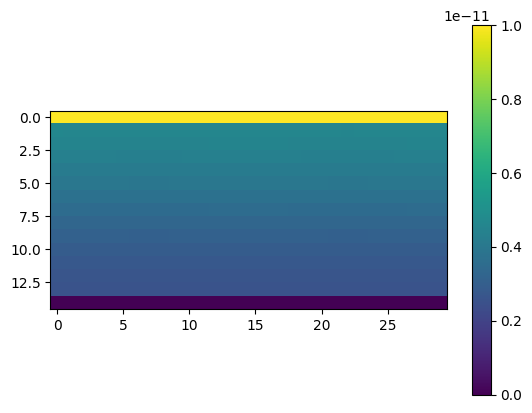

In [17]:
met="glc_D[e]"
im = sim.get_metabolite_image(met, 10)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()

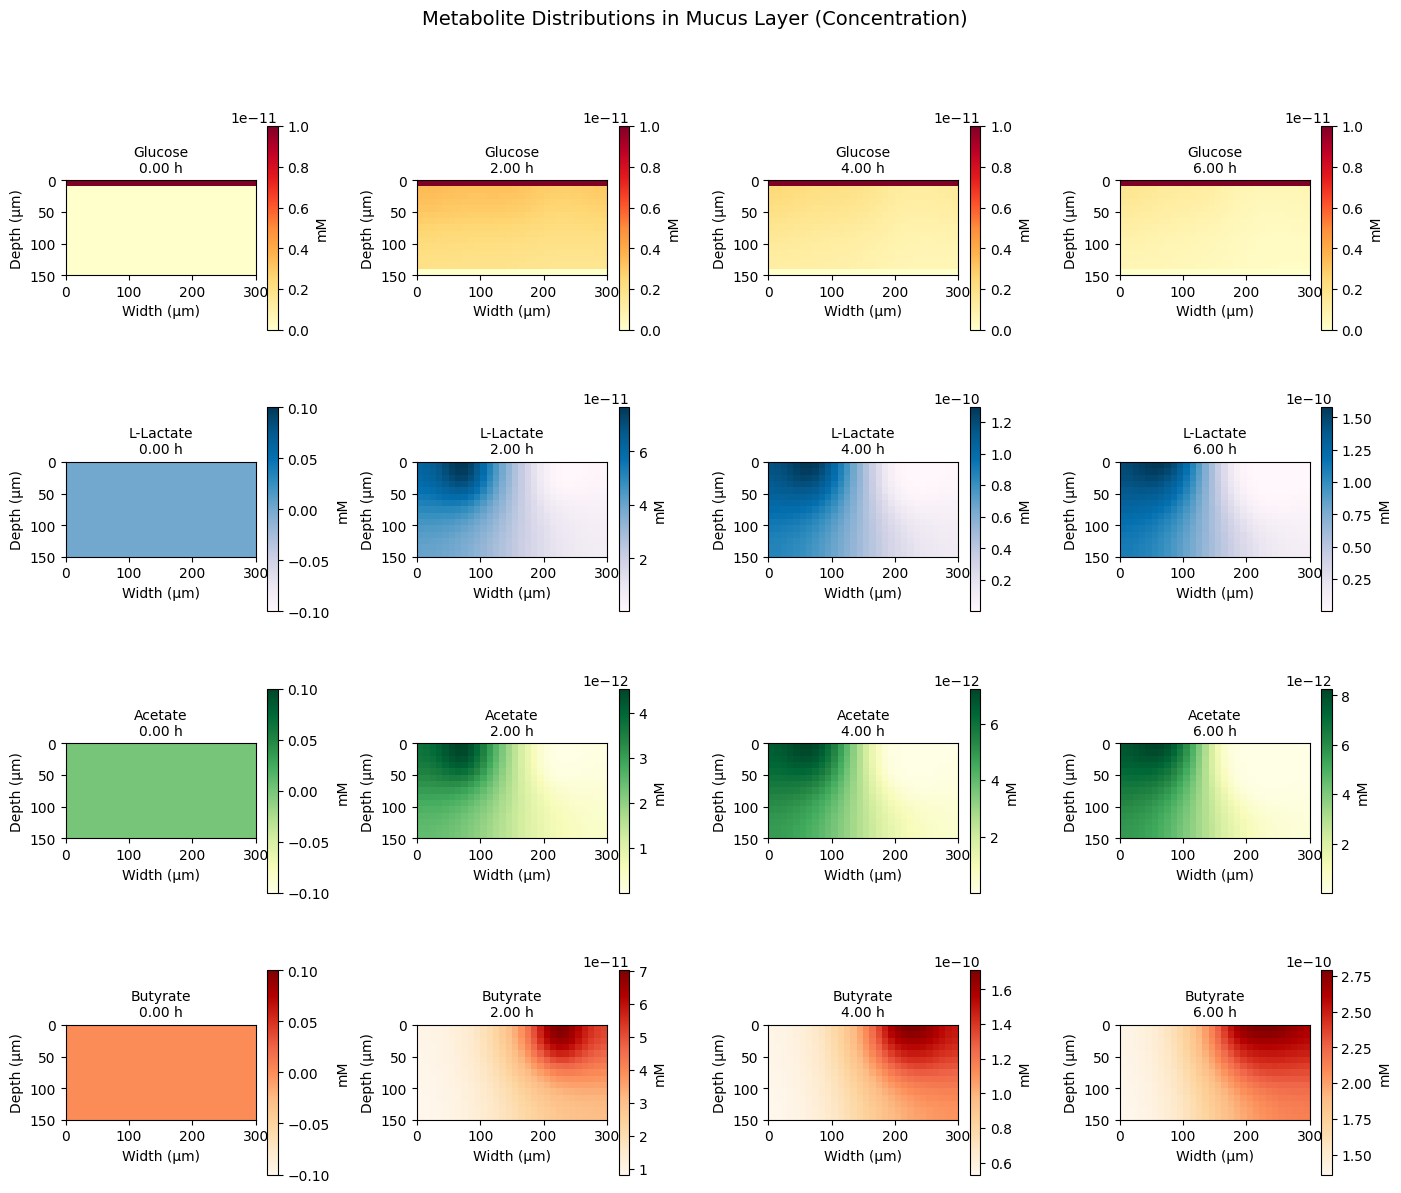

In [18]:
# Metabolite Heatmaps Over Time
cycles = [0, 200, 400, 600]  
metabolites = [
    ('glc_D[e]', 'Glucose', 'YlOrRd'),
    ('lac_L[e]', 'L-Lactate', 'PuBu'),
    ('ac[e]',    'Acetate',  'YlGn'),
    ('but[e]',   'Butyrate', 'OrRd'),
]

n_mets = len(metabolites)

fig, axes = plt.subplots(n_mets, len(cycles), figsize=(3.5*len(cycles), 3*n_mets))
if n_mets == 1:
    axes = axes.reshape(1, -1)

for col, cyc in enumerate(cycles):
    for row, (met_id, met_name, cmap) in enumerate(metabolites):
        ax = axes[row, col]

        # COMETS returns mmol per box; convert to mM
        im = sim.get_metabolite_image(met_id, cyc)
        im_mM = im / BOX_VOL_L  # convert to mM.    im_mM.max()

        pcm = ax.imshow(
            im.T,
            origin='upper',
            cmap=cmap,
            aspect='equal',
            extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0],
        )

        ax.set_title(f'{met_name}\n{cyc*0.01:.2f} h', fontsize=10)
        ax.set_xlabel('Width (µm)')
        ax.set_ylabel('Depth (µm)')
        plt.colorbar(pcm, ax=ax, shrink=0.7, label='mM')

plt.suptitle('Metabolite Distributions in Mucus Layer (Concentration)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

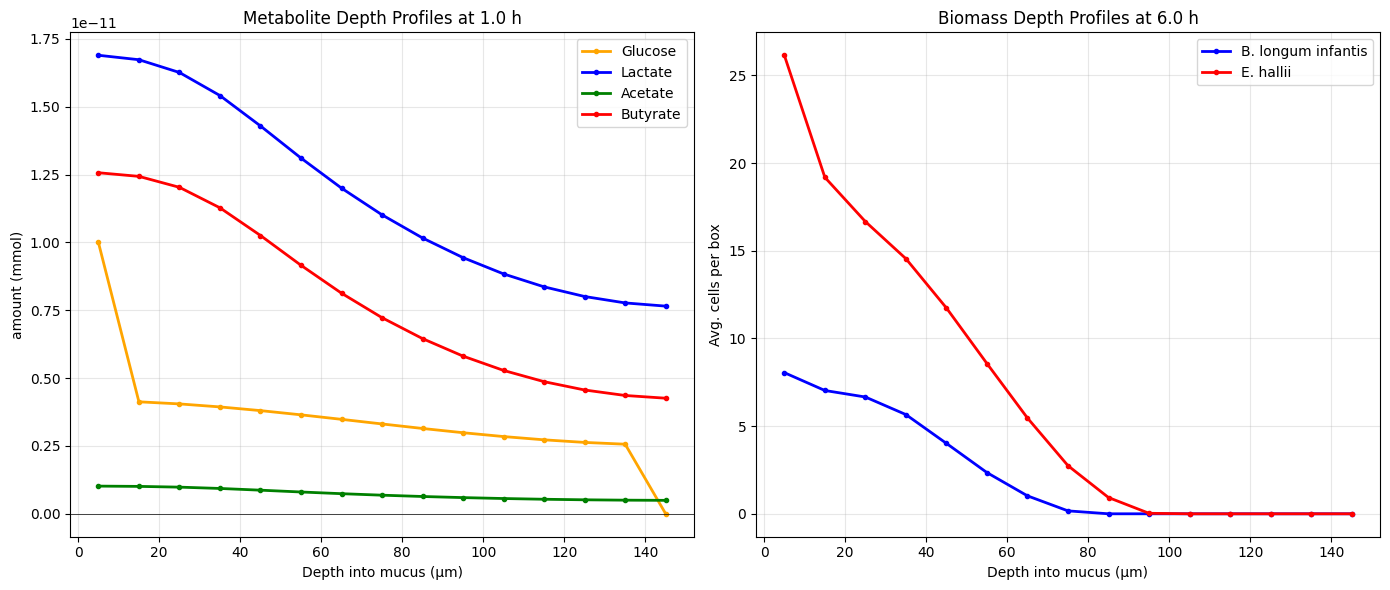

In [19]:
#Amount vs Mucus Depth

cyc = 100
depth_um = np.arange(GRID_Y) * SPACE_WIDTH * 1e4 + SPACE_WIDTH * 1e4 / 2  # center of each row

profile_mets = [
    ('glc_D[e]', 'Glucose', 'orange'),
    ('lac_L[e]', 'Lactate', 'blue'),
    ('ac[e]',    'Acetate', 'green'),
    ('but[e]',   'Butyrate', 'red'),
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: metabolite depth profiles
for met_id, met_name, color in profile_mets:

    im = sim.get_metabolite_image(met_id, cyc)
    avg_profile = im.mean(axis=0)  # average across x
    #conc_profile = avg_profile / BOX_VOL_L  # convert to mM
    ax1.plot(depth_um, avg_profile, color=color, linewidth=2, label=met_name, marker='o', markersize=3)


ax1.set_xlabel('Depth into mucus (µm)')
ax1.set_ylabel('amount (mmol)')
ax1.set_title(f'Metabolite Depth Profiles at {cyc*0.01:.1f} h')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linewidth=0.5)

# Right: biomass depth profiles
cyc= int(tb['cycle'].max())
for species, color, label in [('Bifido', 'blue', 'B. longum infantis'), ('Eubacterium', 'red', 'E. hallii')]:
    im = sim.get_biomass_image(species, cyc)
    im = np.roll(im, shift=1, axis=1)
    depth_profile = im.mean(axis=0)  # average across x
    # Convert to cells per box: 1 bacterium ≈ 1e-12 g
    cells_profile = depth_profile / 1e-12
    ax2.plot(depth_um, cells_profile, color=color, linewidth=2, label=label, marker='o', markersize=3)

ax2.set_xlabel('Depth into mucus (µm)')
ax2.set_ylabel('Avg. cells per box')
ax2.set_title(f'Biomass Depth Profiles at {cyc*0.01:.1f} h')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('depth_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

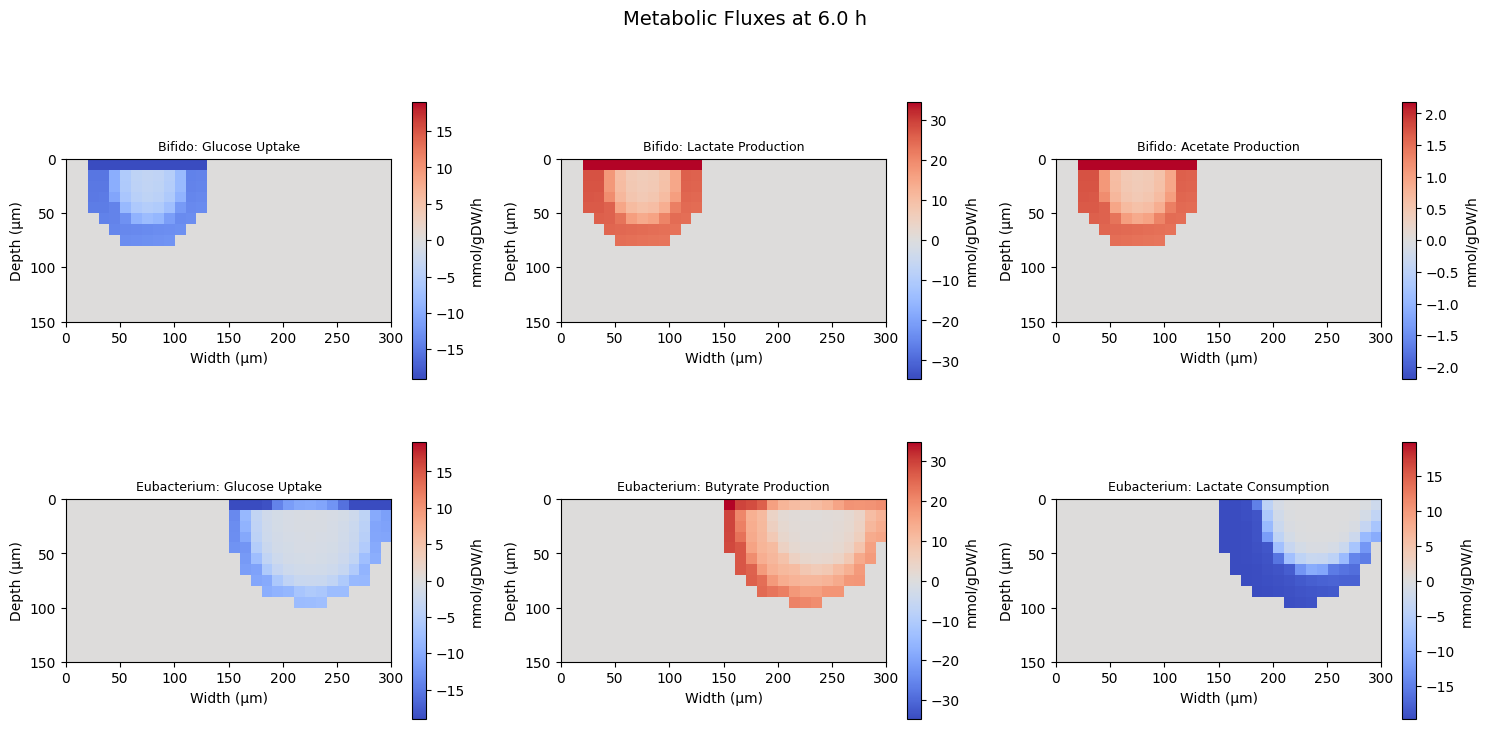

In [20]:
# Key Flux Maps 
max_cycle =  int(tb['cycle'].max())
cyc = max_cycle

flux_pairs = [
    ('Bifido',      'EX_glc_D(e)',  'Bifido: Glucose Uptake'),
    ('Bifido',      'EX_lac_L(e)',  'Bifido: Lactate Production'),
    ('Bifido',      'EX_ac(e)',     'Bifido: Acetate Production'),
    ('Eubacterium', 'EX_glc_D(e)',  'Eubacterium: Glucose Uptake'),
    ('Eubacterium', 'EX_but(e)',    'Eubacterium: Butyrate Production'),
    ('Eubacterium', 'EX_lac_L(e)',  'Eubacterium: Lactate Consumption'),
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes_flat = axes.flatten()

for idx, (species, rxn, title) in enumerate(flux_pairs):
    ax = axes_flat[idx]

    im = sim.get_flux_image(species, rxn, cyc).astype(float)
    vmax = max(abs(im).max(), 1e-20)
    pcm = ax.imshow(im.T, origin='upper', cmap='coolwarm', aspect='equal',
                    vmin=-vmax, vmax=vmax,
                    extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0])
    ax.set_title(title, fontsize=9)
    ax.set_xlabel('Width (µm)')
    ax.set_ylabel('Depth (µm)')
    plt.colorbar(pcm, ax=ax, shrink=0.7, label='mmol/gDW/h')


plt.suptitle(f'Metabolic Fluxes at {cyc*0.01:.1f} h', fontsize=14)
plt.tight_layout()
#plt.savefig('flux_maps.png', dpi=150, bbox_inches='tight')
plt.show()

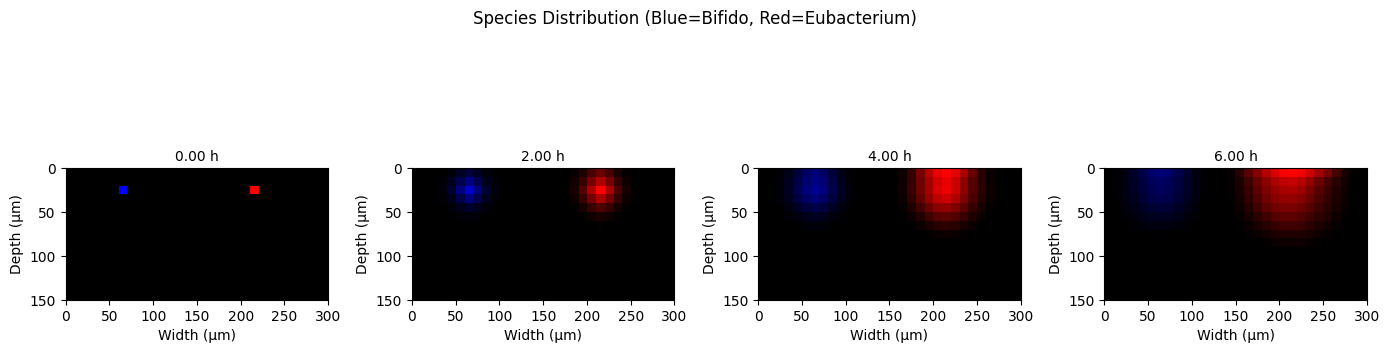

In [21]:
# Species Overlay 

cycles = [0, 200, 400, 600]  

fig, axes = plt.subplots(1, len(cycles), figsize=(3.5*len(cycles), 4))
if len(cycles) == 1:
    axes = [axes]

for i, cyc in enumerate(cycles):
    ax = axes[i]

    im_b = sim.get_biomass_image('Bifido', cyc)
    im_e = sim.get_biomass_image('Eubacterium', cyc)
    im_b = np.roll(im_b, shift=1, axis=1)  # bug fix with np.roll
    im_e = np.roll(im_e, shift=1, axis=1)

    # Normalize both species to [0, 1] using a common scale
    bmax = max(im_b.max(), 1e-20)
    emax = max(im_e.max(), 1e-20)
    scale = max(bmax, emax)

    rgb = np.zeros((GRID_Y, GRID_X, 3))
    rgb[:, :, 2] = (im_b / scale).T  # Bifido = blue
    rgb[:, :, 0] = (im_e / scale).T  # Eubacterium = red
    rgb = np.clip(rgb, 0, 1)

    ax.imshow(
        rgb,
        origin='upper',
        aspect='equal',
        extent=[0, GRID_X*SPACE_WIDTH*1e4, GRID_Y*SPACE_WIDTH*1e4, 0],
    )
    ax.set_title(f'{cyc*0.01:.2f} h', fontsize=10)
    ax.set_xlabel('Width (µm)')
    ax.set_ylabel('Depth (µm)')

plt.suptitle('Species Distribution (Blue=Bifido, Red=Eubacterium)', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

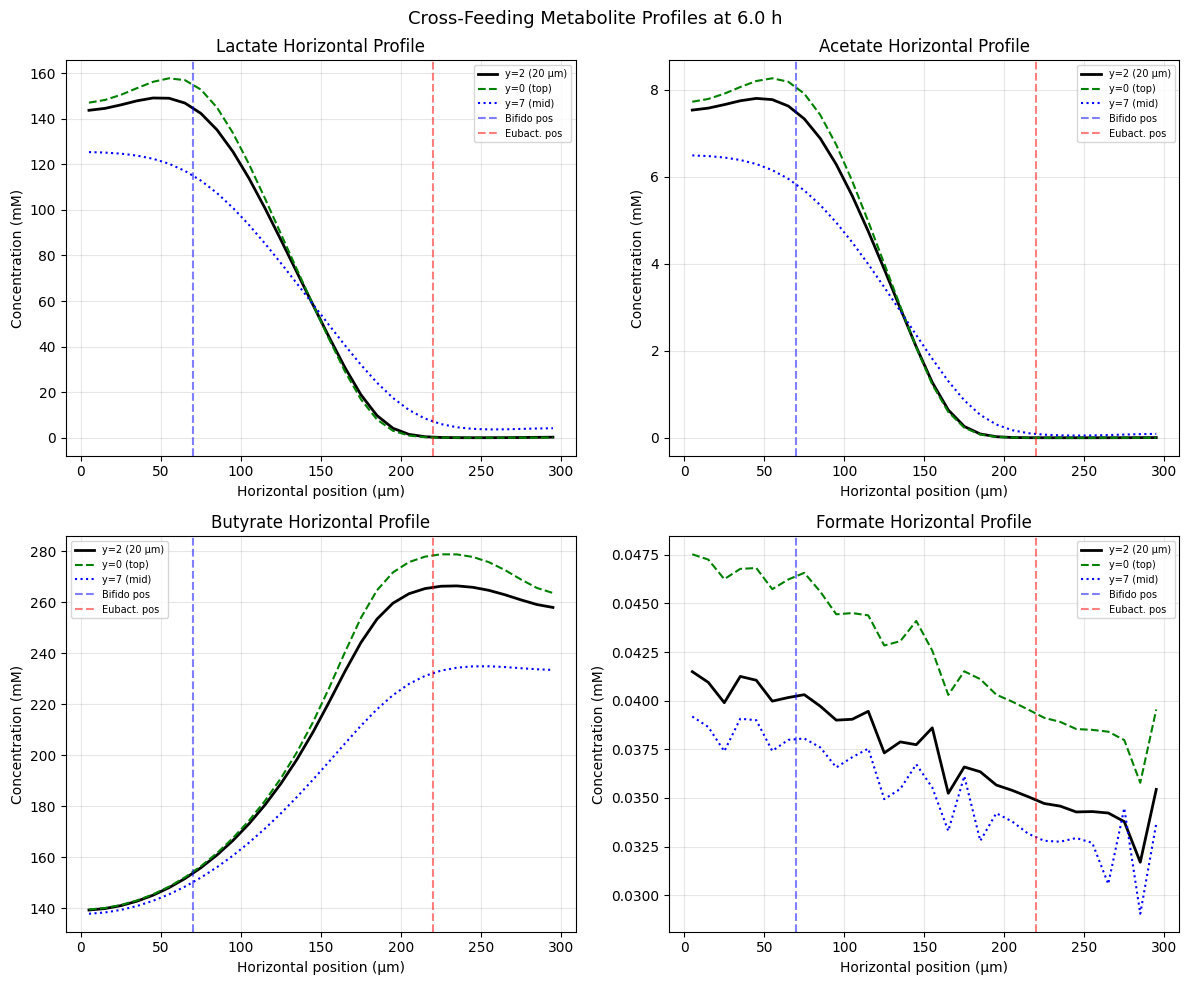

In [22]:
# Analyze metabolite exchange between species

cyc = max_cycle

crossfeed_mets = [
    ('lac_L[e]', 'Lactate'),
    ('ac[e]', 'Acetate'),
    ('but[e]', 'Butyrate'),
    ('for[e]', 'Formate'),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes_flat = axes.flatten()
x_um = np.arange(GRID_X) * SPACE_WIDTH * 1e4 + SPACE_WIDTH * 1e4 / 2

for idx, (met_id, met_name) in enumerate(crossfeed_mets):
    ax = axes_flat[idx]

    im = sim.get_metabolite_image(met_id, cyc)
    im_mM = im / BOX_VOL_L
    
    # Profile at y=2 (inoculation row)
    profile_y2 = im_mM[:, y_init]
    ax.plot(x_um, profile_y2, 'k-', linewidth=2, label=f'y={y_init} ({y_init*10} µm)')
    
    # Profile at y=0 (top)
    profile_y0 = im_mM[:, 0]
    ax.plot(x_um, profile_y0, 'g--', linewidth=1.5, label='y=0 (top)')
    
    # Profile at y=7 (mid-depth)
    profile_ymid = im_mM[:, GRID_Y//2]
    ax.plot(x_um, profile_ymid, 'b:', linewidth=1.5, label=f'y={GRID_Y//2} (mid)')
    
    ax.axvline(x=x_bif*SPACE_WIDTH*1e4, color='blue', linestyle='--', alpha=0.5, label='Bifido pos')
    ax.axvline(x=x_eub*SPACE_WIDTH*1e4, color='red', linestyle='--', alpha=0.5, label='Eubact. pos')
    
    ax.set_xlabel('Horizontal position (µm)')
    ax.set_ylabel('Concentration (mM)')
    ax.set_title(f'{met_name} Horizontal Profile')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)
   
plt.suptitle(f'Cross-Feeding Metabolite Profiles at {cyc*0.01:.1f} h', fontsize=13)
plt.tight_layout()
#plt.savefig('crossfeeding_analysis.png', dpi=150, bbox_inches='tight')
plt.show()